Unpack the data from the pickle files

In [ ]:
import pickle
import tensorflow as tf

In [ ]:
with open('hw4_trs.pkl','rb') as file:
  tr_data=pickle.load(file)

with open('hw4_tes.pkl','rb') as file:
  te_data=pickle.load(file)

In [ ]:
tr_data.shape,te_data.shape

((500, 16180), (200, 22631))

Compute the magnitude spectrum for all the rows in the training and test audio files

In [ ]:
import librosa
import numpy as np

tr_spect=[]
for i in range(len(tr_data)):
  tr_spect.append(np.abs(librosa.stft(tr_data[i], n_fft=1024, hop_length=512)))

In [ ]:
te_spect=[]
for i in range(len(te_data)):
  te_spect.append(np.abs(librosa.stft(te_data[i], n_fft=1024, hop_length=512)))

In [ ]:

tr_data=np.array(tr_spect)
te_data=np.array(te_spect)


In [ ]:
tr_data.shape,te_data.shape

((500, 513, 32), (200, 513, 45))

Prepare the training and test datasets for our model. Both the datasets contain pairs of magnitude spectrums. Each Pair represent either a posive or negative training pair samples. 


In [ ]:

def preprocess(data):
  input_1=[]
  input_2=[]
  labels=[]


  for i in range(0,len(data),10):
    positive_x1=data[np.random.choice(list(range(i,i+10)),size=45,replace=True)]
    positive_x2=data[np.random.choice(list(range(i,i+10)),size=45,replace=True)]

    negative_x1=data[np.random.choice(list(range(i,i+10)),size=45,replace=True)]
    negative_x2=data[np.random.choice(list(range(0,i))+list(range(i+10,len(data))),size=45,replace=False)]

    if len(input_1)!=0 and len(input_2)!=0 and len(labels)!=0:
      input_1=np.concatenate((input_1,positive_x1,negative_x1))
      input_2=np.concatenate((input_2,positive_x2,negative_x2))

      labels=np.concatenate((labels,np.ones((45,1)),np.zeros((45,1))))  

    else:
      input_1=np.concatenate((positive_x1,negative_x1))
      input_2=np.concatenate((positive_x2,negative_x2))

      labels=np.concatenate((np.ones((45,1)),np.zeros((45,1))))

  return input_1,input_2,labels  



In [ ]:
tr_input_1,tr_input_2,tr_labels=preprocess(tr_data)

In [ ]:
tr_input_1.shape,tr_input_2.shape,tr_labels.shape

((4500, 513, 32), (4500, 513, 32), (4500, 1))

In [ ]:
te_input_1,te_input_2,te_labels=preprocess(te_data)

In [ ]:
te_input_1.shape,te_input_2.shape,te_labels.shape

((1800, 513, 45), (1800, 513, 45), (1800, 1))

The training set has data of 50 speakers each with 10 recordings. So, I created 45 positive and 45 negative sample pairs for each speaker. Therefore, we will have 50*(45+45)=4500 samples each with 513 frequency components and 32 time steps(45 time steps for test) in the pairs.

**Note:** I do not create a batch of samples for each speaker here. Instead I pass the batch size as 90 in the training loop.

Time to build the model. The Siamese network has two sister networks which compute the embeddings for the pair of inputs. The dot product of both these embeddings are passed through a logistic function to compute whether or not the samples belong to the same person.

In the following cells, I have will build a helper function to generate the sister networks of our Siamese Model, and then I will use the embeddings from each of these newtworks to generate the label.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
def build_sister_model(inputShape, embeddingDim=48):
  inputs = Input(inputShape)
  x = LSTM(activation='tanh',units=64,return_sequences=False,name='layer_1')(inputs)
  outputs = Dense(units=embeddingDim,activation='relu',kernel_initializer='HeNormal')(x)
  model = Model(inputs, outputs)
  return model

In [ ]:
imgA = Input((None,513))
imgB = Input((None,513))

embeddingsExtractor = build_sister_model((None,513))

featsA = embeddingsExtractor(imgA)
featsB = embeddingsExtractor(imgB)

In [ ]:
distance=tf.expand_dims(tf.reduce_sum(tf.multiply(featsA, featsB),axis=1),axis=-1)

In [ ]:
outputs = Dense(1, activation="sigmoid",kernel_initializer='GlorotNormal')(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(),
	metrics=["accuracy"])

In [ ]:
tr_input_1.shape

(4500, 513, 32)

In [ ]:
tr_input_1=np.transpose(tr_input_1,axes=(0,2,1))
tr_input_2=np.transpose(tr_input_2,axes=(0,2,1))
te_input_1=np.transpose(te_input_1,axes=(0,2,1))
te_input_2=np.transpose(te_input_2,axes=(0,2,1))

In [ ]:
tr_input_1.shape

(4500, 32, 513)

In [ ]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None, 513)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, None, 513)]  0                                            
__________________________________________________________________________________________________
functional_25 (Functional)      (None, 48)           151088      input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Mul_12 (TensorFlowO [(None, 48)]         0           functional_25[0][0]  

Now, lets plot the model to check if our architecture is right- 

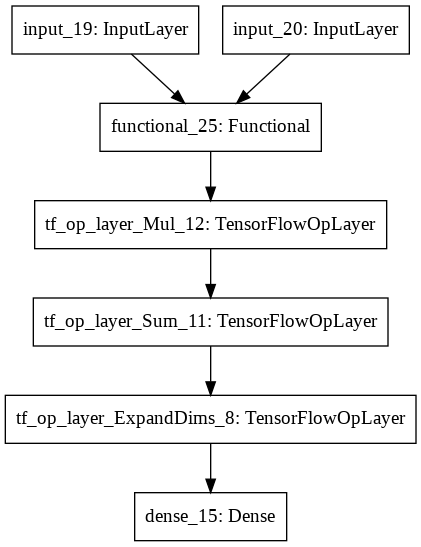

In [ ]:
tf.keras.utils.plot_model(model)

Now, lets train the model. We also pass the validation set to evaluate our model during training.

In [ ]:
history = model.fit(
	[tr_input_1, tr_input_2], tr_labels,
	validation_data=([te_input_1,te_input_2], te_labels),
	batch_size=90, 
	epochs=100
  )

Epoch 1/100
50/50 [==============================] - 1s 29ms/step - loss: 0.6903 - accuracy: 0.5129 - val_loss: 0.6804 - val_accuracy: 0.5544
Epoch 2/100
50/50 [==============================] - 1s 15ms/step - loss: 0.6521 - accuracy: 0.5956 - val_loss: 0.6712 - val_accuracy: 0.5911
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 0.6115 - accuracy: 0.6742 - val_loss: 0.6554 - val_accuracy: 0.6228
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 0.5619 - accuracy: 0.7484 - val_loss: 0.6433 - val_accuracy: 0.6589
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 0.5198 - accuracy: 0.8029 - val_loss: 0.6371 - val_accuracy: 0.6861
Epoch 6/100
50/50 [==============================] - 1s 15ms/step - loss: 0.4764 - accuracy: 0.8393 - val_loss: 0.6122 - val_accuracy: 0.6878
Epoch 7/100
50/50 [==============================] - 1s 15ms/step - loss: 0.4374 - accuracy: 0.8736 - val_loss: 0.6206 - val_accuracy: 0.6989
Epoch 

From the above training logs we can see that our model overfits the data. But, the validation accuracy is close to 70%

In [ ]:
test_acc=(sum((model.predict([te_input_1,te_input_2])>=0.5)==te_labels)/len(te_labels))[0]*100

Final Validation Accuracy-

In [ ]:
print(f'Final Test Accuracy {round(test_acc,2)}')

Final Test Accuracy 67.67
